## PropDRM - deep learning from propositionalized data structures

This notebook serves as an illustratory example of the PropDRM approach, proposed by Lavrač et al. (MLJ, 2020).
The key idea of PropDRM builds on the concept of Wordification (Chapter 3), coupled with modern deep neural networks. The implementation in this notebook follows the key ideas in the paper, however, for the C++ version of the code (the original), please consult: https://github.com/SkBlaz/PropStar

- python-rdm==0.3.5
- tabulate==0.8.7
- tensorflow >= 2.0
- shap>=0.37
- seaborn>=0.38
- matplotlib>=3.0.0

We begin by refreshing the notion of Wordification:

In [1]:
## initial data loading
import requests
request = requests.get('https://raw.githubusercontent.com/xflows/rdm/master/examples/data/trains/trains.csv')
with open("data/trains.csv", "wb") as file:
    file.write(request.content)
request = requests.get('https://raw.githubusercontent.com/xflows/rdm/master/examples/data/trains/cars.csv')
with open("data/cars.csv", "wb") as file:
    file.write(request.content)

Next, a relational database is read into the RAM.

In [2]:
import csv
from IPython.display import HTML, display
import tabulate
with open('data/trains.csv') as csvfile:
    rows = [row for row in csv.reader(csvfile)]
print('table "trains"')
display(HTML(tabulate.tabulate(rows[:5], tablefmt='html', showindex=True)))

with open('data/cars.csv') as csvfile:
    rows = [row for row in csv.reader(csvfile)]
print('table "cars"')
display(HTML(tabulate.tabulate(rows[:10], tablefmt='html', showindex=True)))

table "trains"


0,id,direction
1,integer,varchar
2,primary key,
3,1,east
4,2,east


table "cars"


0,id,tid,position,shape,len,sides,roof,wheels,load_shape,load_num
1,integer,integer,integer,varchar,varchar,varchar,varchar,integer,varchar,integer
2,primary key,foreign key [trains.id],,,,,,,,
3,1,1,1,rectangle,short,not_double,none,2,circle,1
4,2,1,2,rectangle,long,not_double,none,3,hexagon,1
5,3,1,3,rectangle,short,not_double,peaked,2,triangle,1
6,4,1,4,rectangle,long,not_double,none,2,rectangle,3
7,5,2,1,rectangle,short,not_double,flat,2,circle,2
8,6,2,2,bucket,short,not_double,none,2,rectangle,1
9,7,2,3,u_shaped,short,not_double,none,2,triangle,1


The Wordification is performed as done in Chapter 3.

In [5]:
from rdm.db import DBContext, CSVConnection
from rdm.db import OrangeConverter
from rdm.wrappers import Wordification

# Establish a connection
connection = CSVConnection(['data/trains.csv','data/cars.csv'])
context = DBContext(connection, target_table='trains', target_att='direction')

# Convert relational context
conv = OrangeConverter(context)

In [83]:
from pprint import pprint

# We'll use TF-IDF scoring
wordificator = Wordification(conv.target_Orange_table(), conv.other_Orange_tables(), context, word_att_length=2)
wordificator.run()
wordificator.calculate_weights(measure='tfidf')
trains_tfidf = wordificator.to_orange()
feature_names = trains_tfidf.domain.attributes

In [50]:
# Prepare for learning
X = trains_tfidf.X
Y = trains_tfidf.Y
y_names = np.array([x.name for x in trains_tfidf.domain.attributes])

# Let's do a 80:20 split
first_half = int(X.shape[0]/5)

# partition the data sets
X_test = X[0:first_half]
X_train = X[first_half:]
Y_test = Y[0:first_half]
Y_train = Y[first_half:]

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# A simple neural network with one hidden layer
model = keras.Sequential()
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=2, verbose=1)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 2,065
Trainable params: 2,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 1.0283 - accuracy: 0.4375
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6971 - accuracy: 0.6250
Epoch 3/100
8/8 [==============================] - 0s 927us/step - loss: 0.9825 - accuracy: 0.5625
Epoch 4/100
8/8 [==============================] - 0s 875us/step - loss: 1.1013 - accura

8/8 [==============================] - 0s 677us/step - loss: 0.3228 - accuracy: 0.8125
Epoch 77/100
8/8 [==============================] - 0s 694us/step - loss: 0.3399 - accuracy: 0.7500
Epoch 78/100
8/8 [==============================] - 0s 877us/step - loss: 0.4175 - accuracy: 0.7500
Epoch 79/100
8/8 [==============================] - 0s 762us/step - loss: 0.5534 - accuracy: 0.6875
Epoch 80/100
8/8 [==============================] - 0s 864us/step - loss: 0.4203 - accuracy: 0.7500
Epoch 81/100
8/8 [==============================] - 0s 970us/step - loss: 0.3249 - accuracy: 0.8125
Epoch 82/100
8/8 [==============================] - 0s 831us/step - loss: 0.3372 - accuracy: 0.7500
Epoch 83/100
8/8 [==============================] - 0s 964us/step - loss: 0.2470 - accuracy: 0.8750
Epoch 84/100
8/8 [==============================] - 0s 655us/step - loss: 0.3477 - accuracy: 0.8750
Epoch 85/100
8/8 [==============================] - 0s 1ms/step - loss: 0.3644 - accuracy: 0.7500
Epoch 86/100
8/

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 1.0, 'Loss during training')

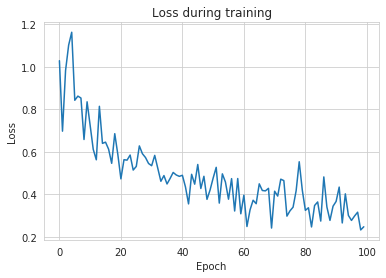

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.lineplot(list(range(len(history.history['loss']))),history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during training")

In [60]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
predictions = [np.round(x) for x in predictions]
crep = classification_report(predictions, Y_test, output_dict = True)['accuracy']
print(f"Achieved Accuracy of {crep}")

Achieved Accuracy of 0.5


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


PropDRM can also be explained by using SHAP tool. But first, we must create a class that can be used as input during explanations.

In [53]:
class NeuralNet:
    """
    A neural network class. This class serves during SHAP-based explanations for its predict_proba capability.
    """
    
    def __init__(self):
        
        ## Initialization of a generic neural network model
        self.model = keras.Sequential()
        self.model.add(keras.Input(shape=(X_train.shape[1],)))
        self.model.add(layers.Dense(8, activation="relu"))
        self.model.add(layers.Dropout(0.2))
        self.model.add(layers.Dense(1, activation="sigmoid"))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    def fit(self, Xdata, Ydata):
        ## A sklearn-like fit function
        self.model.fit(Xdata, Ydata, epochs=100, batch_size=2, verbose=1)
        
    def predict_proba(self, Xdata):
        ## A sklearn-like predict_proba function
        return self.model.predict(Xdata)
        

In [87]:
import shap
import pandas as pd
shap.initjs()

neuralNetwork = NeuralNet()
neuralNetwork.fit(X_train, Y_train)

Epoch 1/100
8/8 [==============================] - 0s 906us/step - loss: 0.9205 - accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 0.8434 - accuracy: 0.4375
Epoch 3/100
8/8 [==============================] - 0s 988us/step - loss: 0.7575 - accuracy: 0.5625
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 0.5591 - accuracy: 0.8750
Epoch 5/100
8/8 [==============================] - 0s 743us/step - loss: 0.6234 - accuracy: 0.6875
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6297 - accuracy: 0.6250
Epoch 7/100
8/8 [==============================] - 0s 1ms/step - loss: 0.5948 - accuracy: 0.6250
Epoch 8/100
8/8 [==============================] - 0s 1ms/step - loss: 0.5686 - accuracy: 0.8125
Epoch 9/100
8/8 [==============================] - 0s 1ms/step - loss: 0.5194 - accuracy: 0.8125
Epoch 10/100
8/8 [==============================] - 0s 975us/step - loss: 0.5254 - accuracy: 0.8125
Epoch 11/100
8/8 [===

8/8 [==============================] - 0s 803us/step - loss: 0.0236 - accuracy: 1.0000
Epoch 84/100
8/8 [==============================] - 0s 943us/step - loss: 0.0353 - accuracy: 1.0000
Epoch 85/100
8/8 [==============================] - 0s 849us/step - loss: 0.0996 - accuracy: 0.9375
Epoch 86/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0431 - accuracy: 1.0000
Epoch 87/100
8/8 [==============================] - 0s 841us/step - loss: 0.0640 - accuracy: 1.0000
Epoch 88/100
8/8 [==============================] - 0s 997us/step - loss: 0.0142 - accuracy: 1.0000
Epoch 89/100
8/8 [==============================] - 0s 807us/step - loss: 0.0273 - accuracy: 1.0000
Epoch 90/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0132 - accuracy: 1.0000
Epoch 91/100
8/8 [==============================] - 0s 856us/step - loss: 0.0577 - accuracy: 1.0000
Epoch 92/100
8/8 [==============================] - 0s 753us/step - loss: 0.0674 - accuracy: 1.0000
Epoch 93/100
8/8 

In [94]:
# use Kernel SHAP to explain test set predictions
X_train = pd.DataFrame(X_train)
X_train.columns = feature_names
X_test = pd.DataFrame(X_test)
X_test.columns = feature_names
explainer = shap.KernelExplainer(neuralNetwork.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

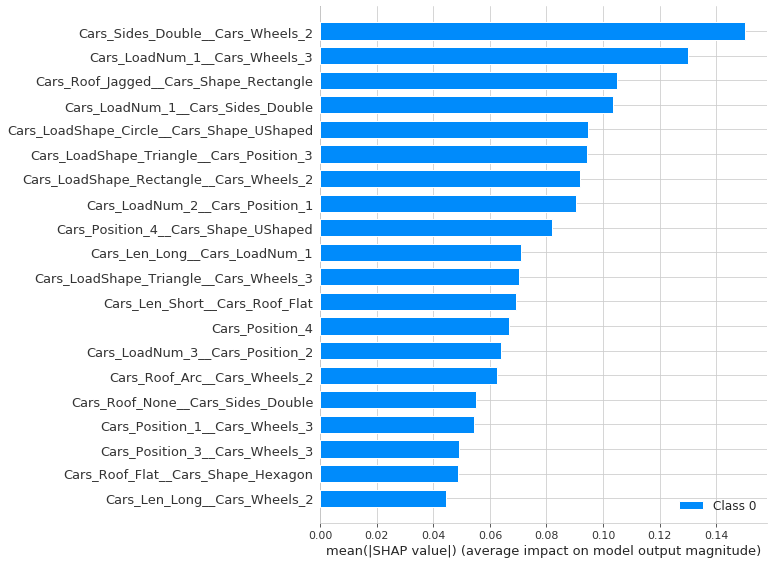

In [95]:
shap.summary_plot(shap_values, X_test) ## Plot the relevances of features on the model output!